# Mental Health Text Classification using NLP
## Team 13: Lekha Kancharla, Ruchith Reddy Parnem, Saketh Desini

This notebook implements mental health text classification using three state-of-the-art models:
- **RoBERTa-base**
- **DeBERTa-v3-large**
- **BiLSTM with FastText embeddings**

Dataset: Kaggle Mental Health Sentiment Analysis (~53K records, 7 classes)

## 1. Setup and Installation

In [ ]:
# Install required packages for Google Colab
!pip install -q transformers datasets accelerate
!pip install -q wordcloud matplotlib seaborn plotly kaleido
!pip install -q scikit-learn nltk spacy
!pip install -q gensim fasttext
!pip install -q emoji  # ADD THIS LINE
!python -m spacy download en_core_web_sm -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 149.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import re
from wordcloud import WordCloud, STOPWORDS
import emoji
from bs4 import BeautifulSoup

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Machine Learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, roc_curve)
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

# Deep Learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
from transformers import (AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n{'='*80}")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"{'='*80}\n")

# Set random seeds for reproducibility
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("✓ All packages installed and GPU configured!")


Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory Available: 85.17 GB

✓ All packages installed and GPU configured!


## 2. Data Loading and Initial Exploration

In [ ]:
# Load the dataset from Kaggle
# OPTION 1: Using Kaggle API (recommended)
import kagglehub

# Download latest version
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

print("Path to dataset files:", path)
# Uncomment and run these lines if using Kaggle API

# !mkdir -p ~/.kaggle
# from google.colab import files
# print("Please upload your kaggle.json file:")
# files.upload()  # Upload kaggle.json
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d suchintikasarkar/sentiment-analysis-formentalhealth
# !unzip -q sentiment-analysis-formentalhealth.zip

# OPTION 2: Manual file upload
# Uncomment and run if uploading CSV manually

#from google.colab import files
#print("Please upload the 'Combined Data.csv' file:")
#uploaded = files.upload()

100%|██████████| 11.1M/11.1M [00:01<00:00, 7.28MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [ ]:
import os
import kagglehub
# Get the path from kagglehub download
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

# Find and load the CSV file
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
csv_file = os.path.join(path, csv_files[0])  # Use first CSV found

print(f"Loading: {os.path.basename(csv_file)}")
df = pd.read_csv(csv_file)

# Display basic information
print("\n" + "="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Dataset Shape: {df.shape}")
print(f"Number of Samples: {len(df)}")
print(f"Number of Features: {len(df.columns)}")
print(f"\nColumn Names: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nFirst 5 rows:")
display(df.head())

# Check for missing values
print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])

# Check data statistics
print("\n" + "="*80)
print("DATASET STATISTICS")
print("="*80)
print(df.describe(include='all'))

# Class distribution
print("\n" + "="*80)
print("CLASS DISTRIBUTION")
print("="*80)
status_column = 'status'  # Adjust if column name is different
class_counts = df[status_column].value_counts()
print(f"\nClass Counts:\n{class_counts}")
print(f"\nClass Percentages:\n{df[status_column].value_counts(normalize=True) * 100}")

# Check for duplicates
print(f"\nDuplicate Rows: {df.duplicated().sum()}")

Loading: Combined Data.csv

DATASET OVERVIEW
Dataset Shape: (53043, 3)
Number of Samples: 53043
Number of Features: 3

Column Names: ['Unnamed: 0', 'statement', 'status']

Data Types:
Unnamed: 0     int64
statement     object
status        object
dtype: object

First 5 rows:


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety



MISSING VALUES ANALYSIS
           Missing Count  Percentage
statement            362    0.682465

DATASET STATISTICS
          Unnamed: 0          statement  status
count   53043.000000              52681   53043
unique           NaN              51073       7
top              NaN  what do you mean?  Normal
freq             NaN                 22   16351
mean    26521.000000                NaN     NaN
std     15312.339501                NaN     NaN
min         0.000000                NaN     NaN
25%     13260.500000                NaN     NaN
50%     26521.000000                NaN     NaN
75%     39781.500000                NaN     NaN
max     53042.000000                NaN     NaN

CLASS DISTRIBUTION

Class Counts:
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

Class Percentages:
status


## 3. Exploratory Data Analysis with Visualizations

In [ ]:
# VISUALIZATION 1: Class Distribution
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Class Distribution (Count)', 'Class Distribution (Percentage)'),
    specs=[[{'type': 'bar'}, {'type': 'pie'}]]
)

# Bar plot
class_counts = df[status_column].value_counts()
fig.add_trace(
    go.Bar(x=class_counts.index, y=class_counts.values,
           marker_color='lightblue', text=class_counts.values,
           textposition='outside'),
    row=1, col=1
)

# Pie chart
fig.add_trace(
    go.Pie(labels=class_counts.index, values=class_counts.values,
           hole=0.3),
    row=1, col=2
)

fig.update_layout(height=500, showlegend=True, title_text="Mental Health Status Distribution")
fig.show()

print("✓ Class distribution visualization complete")

✓ Class distribution visualization complete


In [ ]:
# VISUALIZATION 2: Text Statistics
text_column = 'statement'  # Adjust based on your column name

# Calculate text statistics
df['text_length'] = df[text_column].astype(str).apply(len)
df['word_count'] = df[text_column].astype(str).apply(lambda x: len(x.split()))
df['avg_word_length'] = df[text_column].astype(str).apply(
    lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0
)
df['sentence_count'] = df[text_column].astype(str).apply(lambda x: len(re.findall(r'[.!?]+', x)) + 1)

print("\n" + "="*80)
print("TEXT STATISTICS SUMMARY")
print("="*80)
stats_summary = df[['text_length', 'word_count', 'avg_word_length', 'sentence_count']].describe()
print(stats_summary)

# Create subplots for text statistics
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Character Length Distribution', 'Word Count Distribution',
                   'Average Word Length Distribution', 'Sentence Count Distribution')
)

fig.add_trace(
    go.Histogram(x=df['text_length'], nbinsx=50, name='Char Length',
                marker_color='lightcoral'),
    row=1, col=1
)
fig.add_trace(
    go.Histogram(x=df['word_count'], nbinsx=50, name='Word Count',
                marker_color='lightgreen'),
    row=1, col=2
)
fig.add_trace(
    go.Histogram(x=df['avg_word_length'], nbinsx=30, name='Avg Word Length',
                marker_color='lightyellow'),
    row=2, col=1
)
fig.add_trace(
    go.Histogram(x=df['sentence_count'], nbinsx=20, name='Sentence Count',
                marker_color='lightblue'),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=False, title_text="Text Statistics Distribution")
fig.show()

print("✓ Text statistics visualization complete")


TEXT STATISTICS SUMMARY
        text_length    word_count  avg_word_length  sentence_count
count  53043.000000  53043.000000     53043.000000    53043.000000
mean     574.784816    112.393285         4.316473        7.209585
std      844.707198    163.436684        13.822561       11.389741
min        2.000000      1.000000         1.100000        1.000000
25%       77.000000     15.000000         3.821032        1.000000
50%      313.000000     61.000000         4.090909        4.000000
75%      748.000000    147.500000         4.428571        9.000000
max    32759.000000   6300.000000      3161.875000     1261.000000


✓ Text statistics visualization complete



GENERATING WORD CLOUDS FOR EACH CLASS


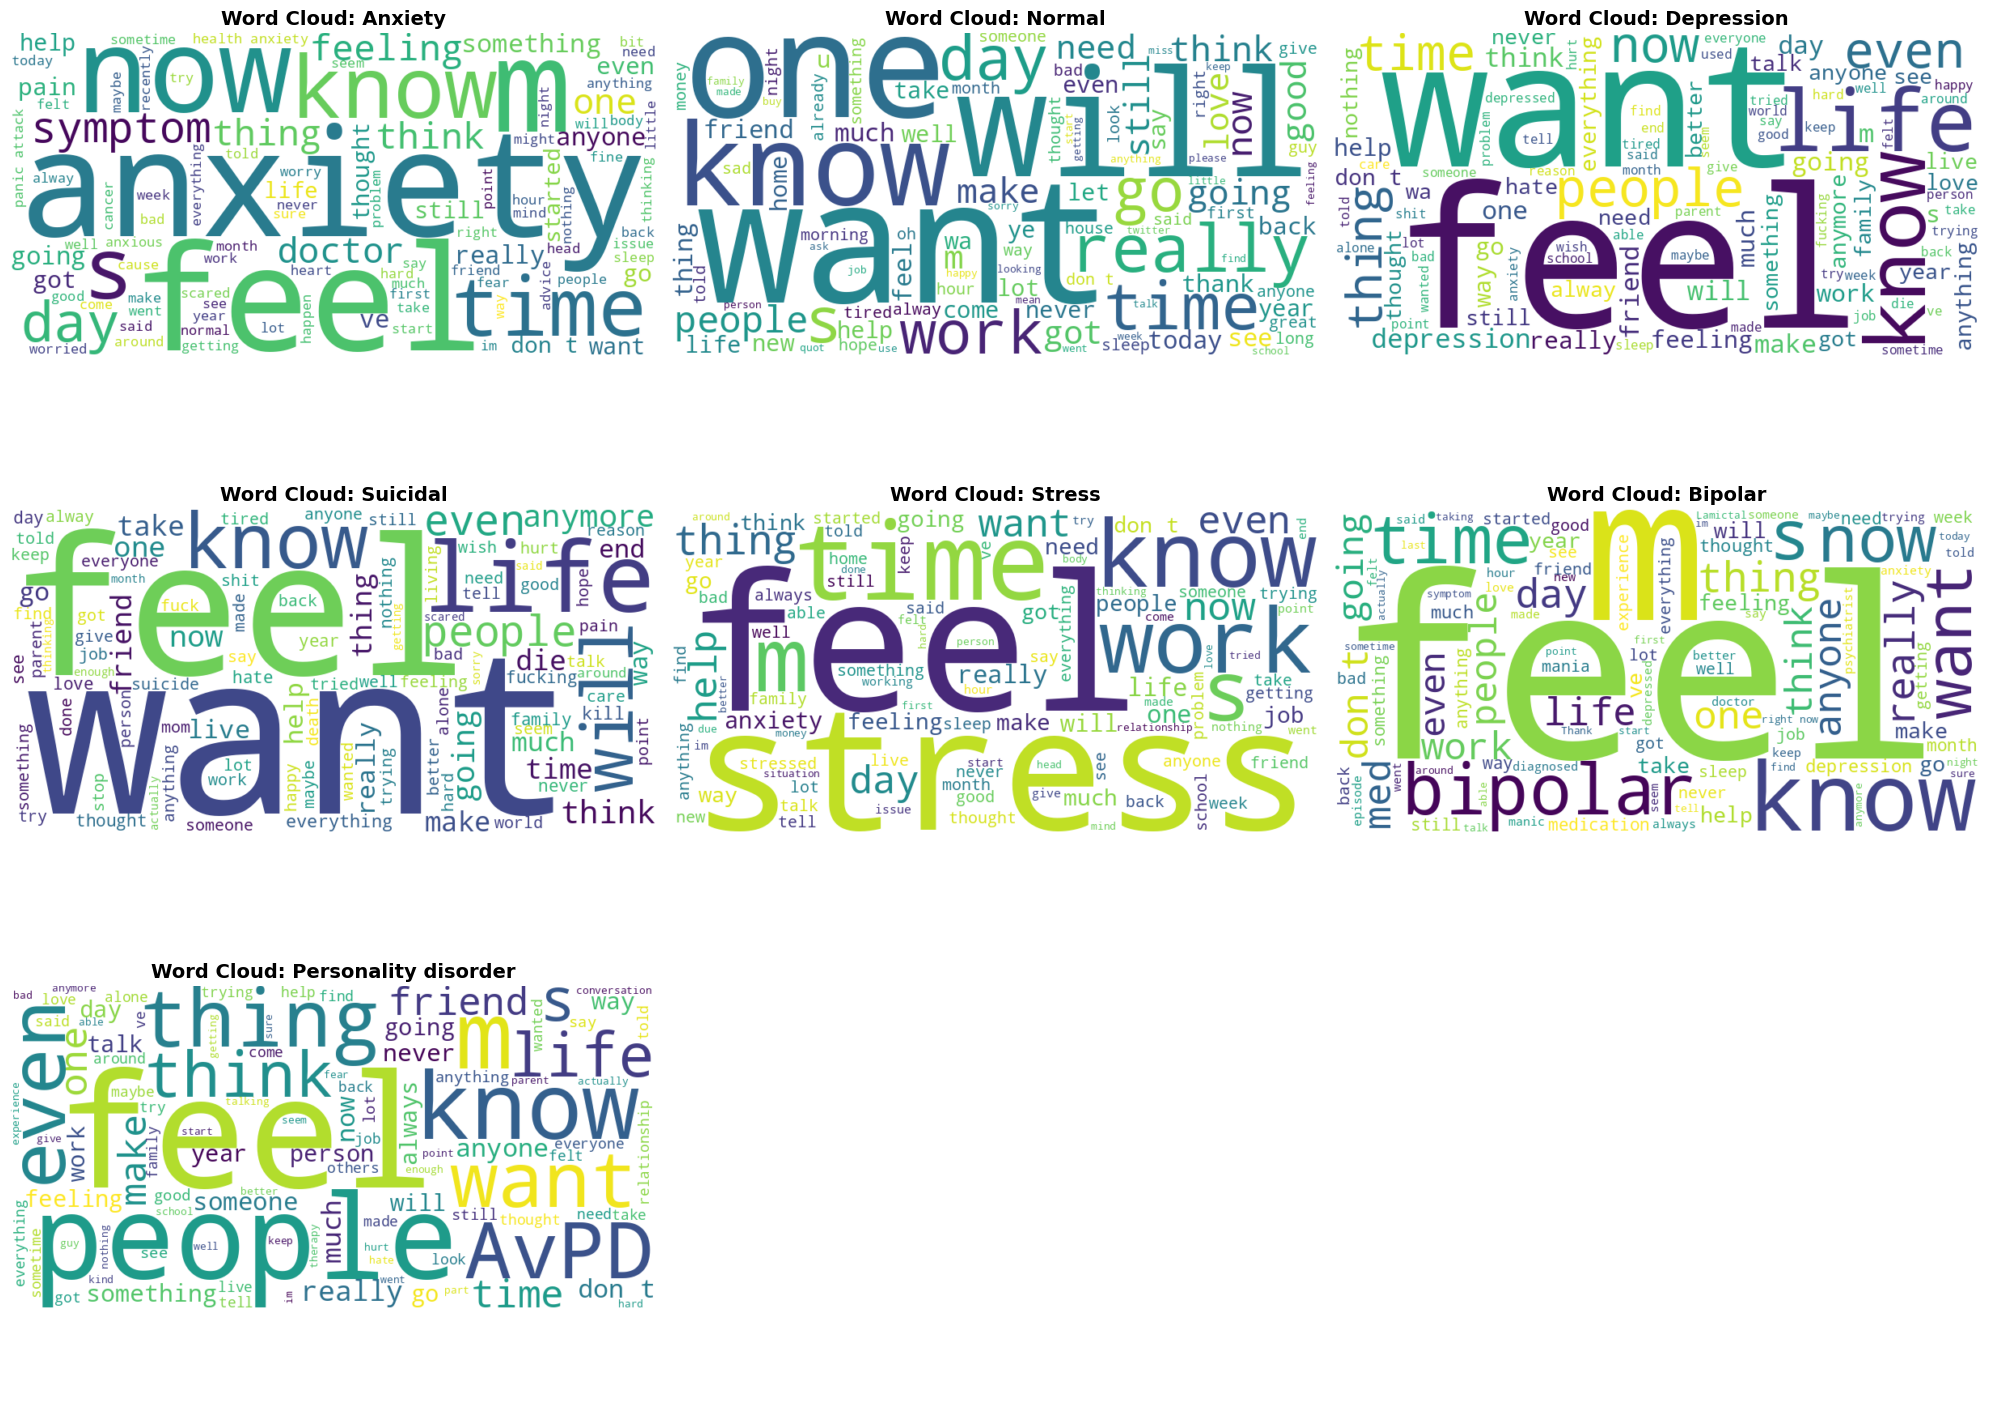

✓ Word clouds generation complete


In [ ]:
# VISUALIZATION 3: Word Clouds per Class
print("\n" + "="*80)
print("GENERATING WORD CLOUDS FOR EACH CLASS")
print("="*80)

n_classes = len(df[status_column].unique())
n_cols = 3
n_rows = (n_classes + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_classes > 1 else [axes]

stopwords_set = set(STOPWORDS)
for idx, status in enumerate(df[status_column].unique()):
    text = ' '.join(df[df[status_column] == status][text_column].astype(str).values)
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=stopwords_set,
        max_words=100,
        colormap='viridis'
    ).generate(text)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Word Cloud: {status}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

# Hide empty subplots
for idx in range(n_classes, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("✓ Word clouds generation complete")

In [ ]:
# Download missing NLTK data
import nltk
nltk.download('punkt_tab', quiet=True)  # Download punkt_tab tokenizer


True


TOP 20 WORDS PER CLASS


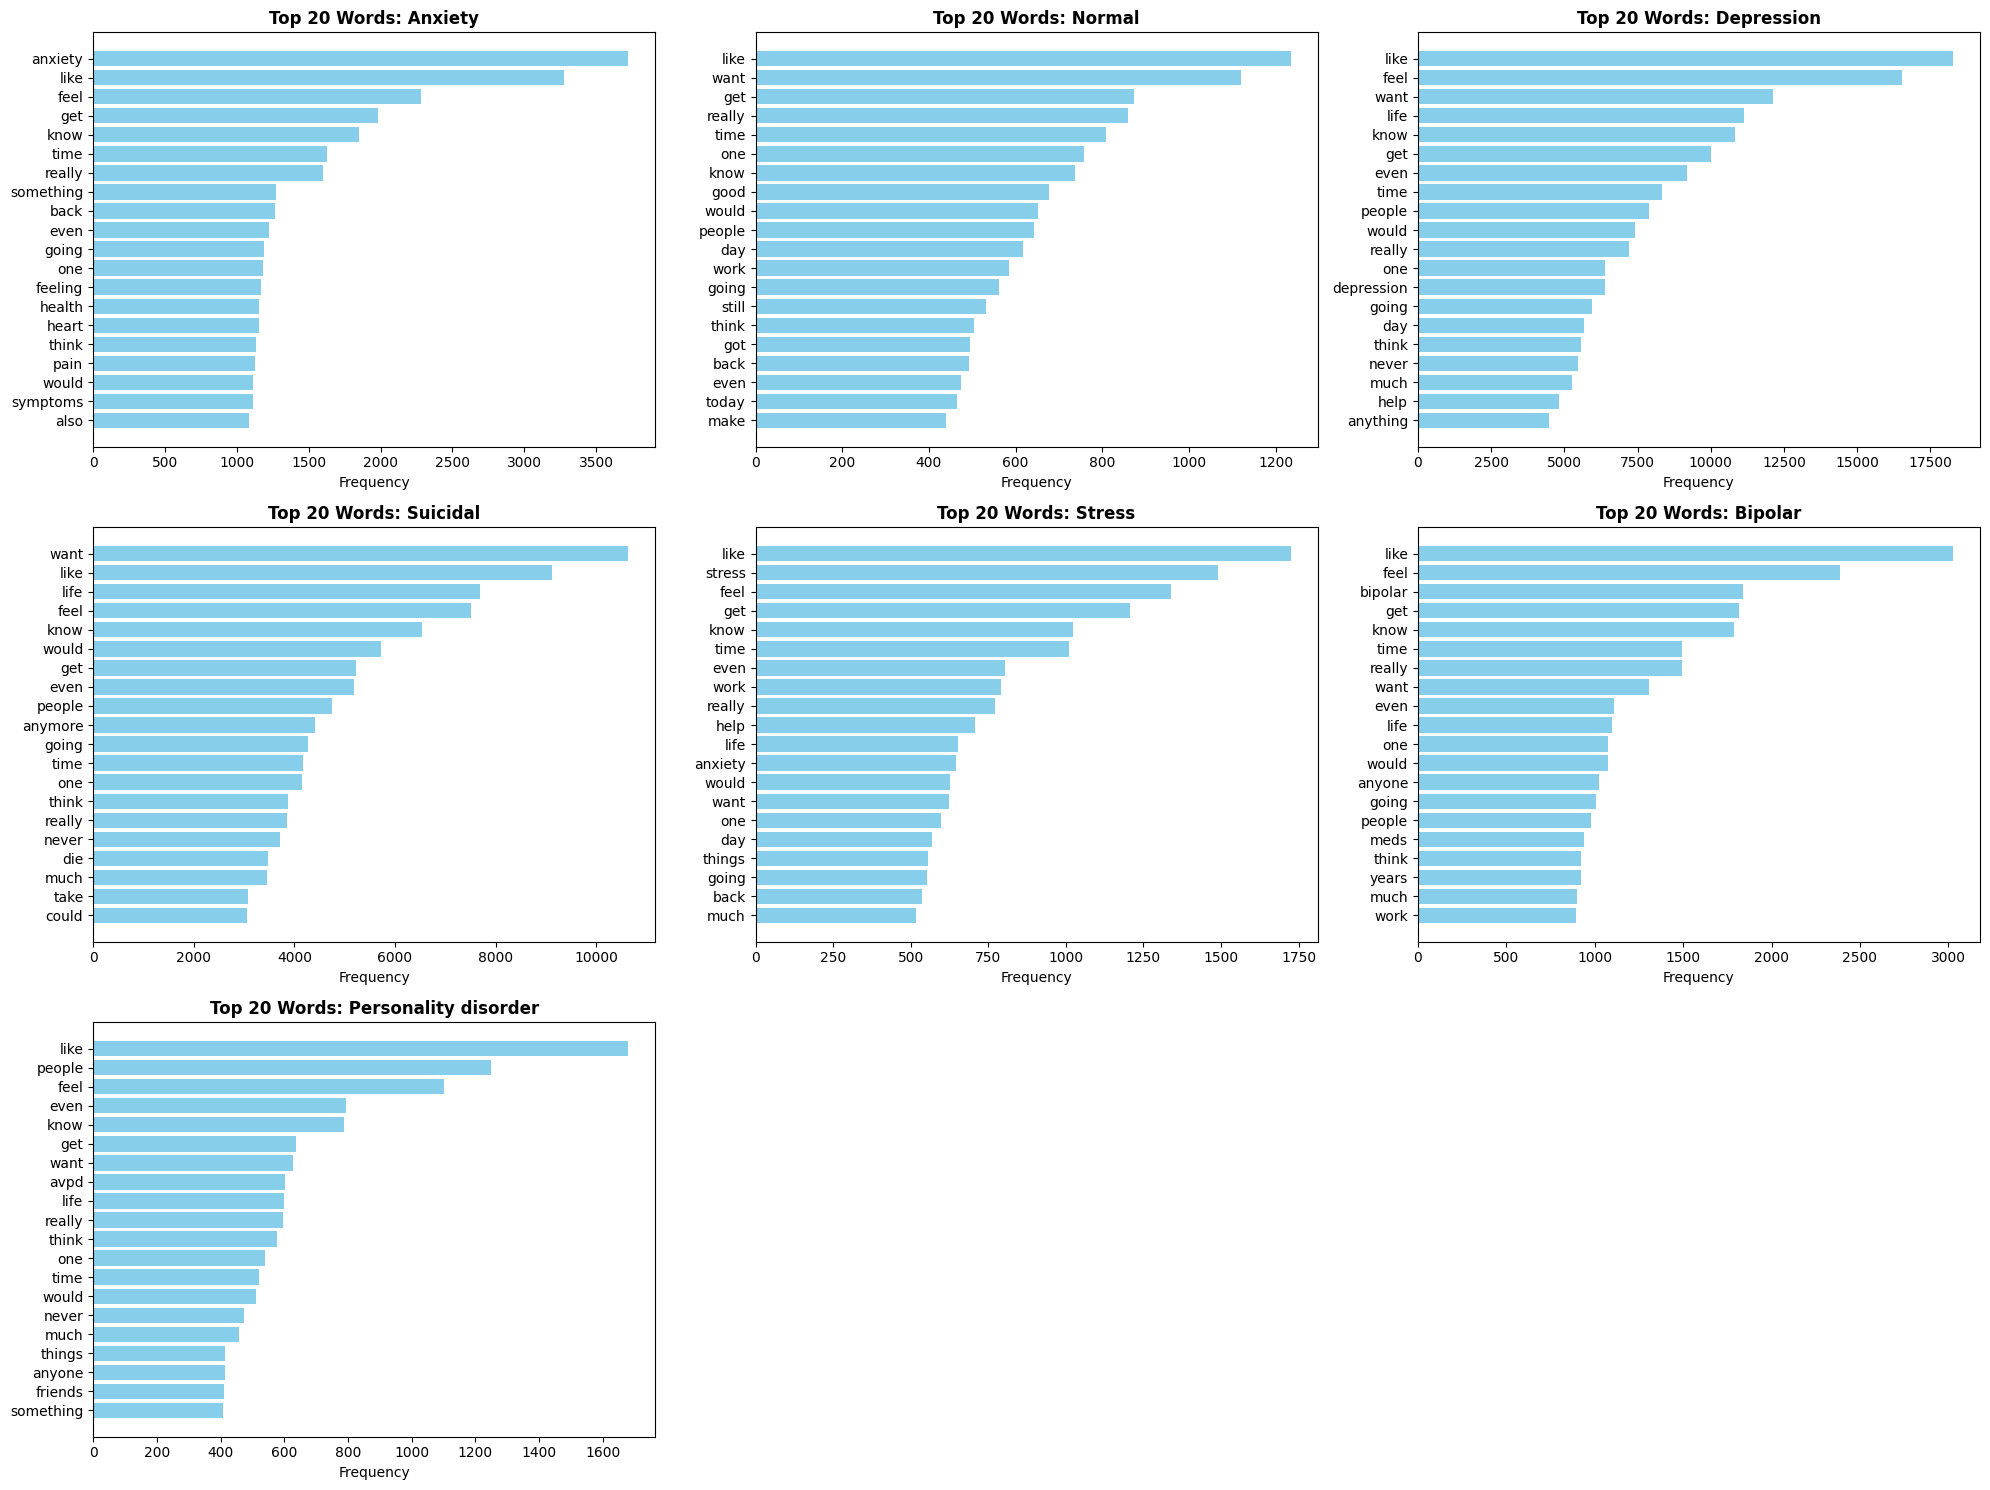

✓ Top words visualization complete


In [ ]:
# VISUALIZATION 4: Top Words per Class
print("\n" + "="*80)
print("TOP 20 WORDS PER CLASS")
print("="*80)

stop_words = set(stopwords.words('english'))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_classes > 1 else [axes]

for idx, status in enumerate(df[status_column].unique()):
    text = ' '.join(df[df[status_column] == status][text_column].astype(str).values)
    words = [word.lower() for word in word_tokenize(text)
             if word.isalpha() and word.lower() not in stop_words and len(word) > 2]
    word_freq = Counter(words).most_common(20)
    words_list, counts_list = zip(*word_freq) if word_freq else ([], [])

    axes[idx].barh(words_list, counts_list, color='skyblue')
    axes[idx].set_xlabel('Frequency')
    axes[idx].set_title(f'Top 20 Words: {status}', fontweight='bold')
    axes[idx].invert_yaxis()

for idx in range(n_classes, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("✓ Top words visualization complete")

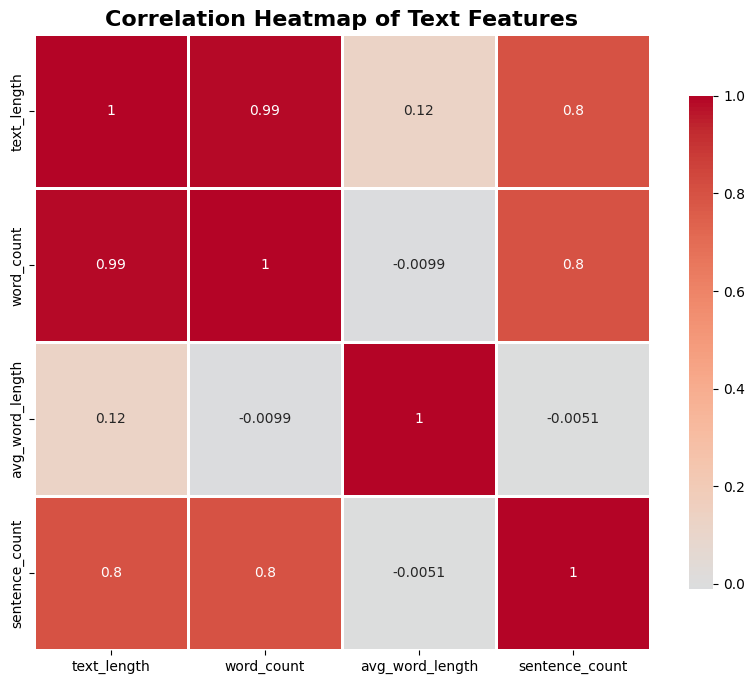

✓ Correlation heatmap complete


In [ ]:
# VISUALIZATION 5: Correlation Heatmap
numeric_features = ['text_length', 'word_count', 'avg_word_length', 'sentence_count']
correlation_matrix = df[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Text Features', fontsize=16, fontweight='bold')
plt.show()

print("✓ Correlation heatmap complete")

## 4. Data Preprocessing and Cleaning

In [ ]:
# TEXT PREPROCESSING CLASS
class TextPreprocessor:
    """Comprehensive text preprocessing for mental health data"""

    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        # Keep important words for mental health
        self.stop_words -= {'not', 'no', 'never', 'nothing', 'nobody',
                            'none', 'neither', 'nor', 'cannot', 'don', 'didn'}

    def clean_text(self, text):
        """Apply comprehensive text cleaning"""
        if pd.isna(text):
            return ""

        text = str(text).lower()
        text = BeautifulSoup(text, "html.parser").get_text()
        text = emoji.demojize(text, delimiters=(" ", " "))
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^a-zA-Z0-9\s.,!?]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def advanced_preprocess(self, text, remove_stopwords=False, lemmatize=True):
        """Apply advanced preprocessing"""
        text = self.clean_text(text)

        if not text:
            return ""

        tokens = word_tokenize(text)

        if remove_stopwords:
            tokens = [word for word in tokens if word not in self.stop_words]

        tokens = [word for word in tokens if len(word) > 1]

        if lemmatize:
            tokens = [self.lemmatizer.lemmatize(word) for word in tokens]

        return ' '.join(tokens)

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Apply preprocessing
print("\n" + "="*80)
print("APPLYING TEXT PREPROCESSING")
print("="*80)

print("Step 1: Basic cleaning...")
df['text_cleaned'] = df[text_column].apply(preprocessor.clean_text)

print("Step 2: Advanced preprocessing...")
df['text_processed'] = df[text_column].apply(
    lambda x: preprocessor.advanced_preprocess(x, remove_stopwords=False, lemmatize=True)
)

# Show examples
print("\n" + "="*80)
print("PREPROCESSING EXAMPLES")
print("="*80)
for i in range(min(3, len(df))):
    print(f"\n--- Example {i+1} ---")
    print(f"Original: {df[text_column].iloc[i][:200]}...")
    print(f"Cleaned: {df['text_cleaned'].iloc[i][:200]}...")
    print(f"Processed: {df['text_processed'].iloc[i][:200]}...")

# Remove empty texts
df = df[df['text_cleaned'].str.len() > 0].reset_index(drop=True)
print(f"\nDataset shape after removing empty texts: {df.shape}")

# Update statistics
df['cleaned_word_count'] = df['text_cleaned'].apply(lambda x: len(x.split()))
df['processed_word_count'] = df['text_processed'].apply(lambda x: len(x.split()))

print("\n" + "="*80)
print("TEXT STATISTICS AFTER PREPROCESSING")
print("="*80)
print(df[['word_count', 'cleaned_word_count', 'processed_word_count']].describe())


APPLYING TEXT PREPROCESSING
Step 1: Basic cleaning...
Step 2: Advanced preprocessing...

PREPROCESSING EXAMPLES

--- Example 1 ---
Original: oh my gosh...
Cleaned: oh my gosh...
Processed: oh my gosh...

--- Example 2 ---
Original: trouble sleeping, confused mind, restless heart. All out of tune...
Cleaned: trouble sleeping, confused mind, restless heart. all out of tune...
Processed: trouble sleeping confused mind restless heart all out of tune...

--- Example 3 ---
Original: All wrong, back off dear, forward doubt. Stay in a restless and restless place...
Cleaned: all wrong, back off dear, forward doubt. stay in a restless and restless place...
Processed: all wrong back off dear forward doubt stay in restless and restless place...

Dataset shape after removing empty texts: (52675, 9)

TEXT STATISTICS AFTER PREPROCESSING
         word_count  cleaned_word_count  processed_word_count
count  52675.000000        52675.000000          52675.000000
mean     113.171429          114.828799  

## 5. Train-Test-Validation Split with Stratification

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df[status_column])

# Create mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

print("\n" + "="*80)
print("LABEL ENCODING")
print("="*80)
print(f"Label Mapping: {label_mapping}")
print(f"Number of Classes: {len(label_mapping)}")

# Stratified train-test-validation split
print("\n" + "="*80)
print("CREATING TRAIN-TEST-VALIDATION SPLIT")
print("="*80)

X = df['text_cleaned'].values
y = df['label'].values

# First split: Train+Val (80%) and Test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

# Second split: Train (80% of train_val) and Val (20% of train_val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.20, random_state=SEED, stratify=y_train_val
)

print(f"Total dataset size: {len(df)}")
print(f"Training set size: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")

# Verify stratification
print("\n" + "="*80)
print("VERIFYING STRATIFICATION")
print("="*80)

splits_df = pd.DataFrame({
    'Train': pd.Series(y_train).value_counts(normalize=True).sort_index() * 100,
    'Validation': pd.Series(y_val).value_counts(normalize=True).sort_index() * 100,
    'Test': pd.Series(y_test).value_counts(normalize=True).sort_index() * 100
})
splits_df.index = [reverse_label_mapping[i] for i in splits_df.index]
print(splits_df.round(2))

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("\n" + "="*80)
print("CLASS WEIGHTS FOR HANDLING IMBALANCE")
print("="*80)
for class_idx, weight in class_weights_dict.items():
    class_name = reverse_label_mapping[class_idx]
    print(f"{class_name}: {weight:.4f}")

# Convert to tensor
class_weights_tensor = torch.FloatTensor(class_weights).to(device)


LABEL ENCODING
Label Mapping: {'Anxiety': np.int64(0), 'Bipolar': np.int64(1), 'Depression': np.int64(2), 'Normal': np.int64(3), 'Personality disorder': np.int64(4), 'Stress': np.int64(5), 'Suicidal': np.int64(6)}
Number of Classes: 7

CREATING TRAIN-TEST-VALIDATION SPLIT
Total dataset size: 52675
Training set size: 33712 (64.0%)
Validation set size: 8428 (16.0%)
Test set size: 10535 (20.0%)

VERIFYING STRATIFICATION
                      Train  Validation   Test
Anxiety                7.29        7.30   7.29
Bipolar                5.27        5.27   5.27
Depression            29.24       29.25  29.25
Normal                31.02       31.02  31.02
Personality disorder   2.05        2.04   2.04
Stress                 4.91        4.91   4.92
Suicidal              20.22       20.22  20.22

CLASS WEIGHTS FOR HANDLING IMBALANCE
Anxiety: 1.9593
Bipolar: 2.7087
Depression: 0.4885
Normal: 0.4606
Personality disorder: 6.9797
Stress: 2.9100
Suicidal: 0.7066


## 6. Model 1: RoBERTa-base Fine-tuning

In [ ]:
print("\n" + "="*80)
print("MODEL 1: ROBERTA-BASE FINE-TUNING")
print("="*80)

# Configuration
MODEL_NAME_ROBERTA = 'roberta-base'
MAX_LENGTH = 512
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_EPOCHS = 10
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01
GRADIENT_ACCUMULATION_STEPS = 2

# Load tokenizer
tokenizer_roberta = AutoTokenizer.from_pretrained(MODEL_NAME_ROBERTA)

# Custom Dataset Class
class MentalHealthDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
print("Creating datasets...")
train_dataset_roberta = MentalHealthDataset(X_train, y_train, tokenizer_roberta, MAX_LENGTH)
val_dataset_roberta = MentalHealthDataset(X_val, y_val, tokenizer_roberta, MAX_LENGTH)
test_dataset_roberta = MentalHealthDataset(X_test, y_test, tokenizer_roberta, MAX_LENGTH)

print(f"Train dataset size: {len(train_dataset_roberta)}")
print(f"Val dataset size: {len(val_dataset_roberta)}")
print(f"Test dataset size: {len(test_dataset_roberta)}")


MODEL 1: ROBERTA-BASE FINE-TUNING


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Creating datasets...
Train dataset size: 33712
Val dataset size: 8428
Test dataset size: 10535


In [ ]:
# Model 1: RoBERTa with Weighted Loss (FINAL CORRECT VERSION)
print("\n" + "="*80)
print("MODEL 1: ROBERTA-BASE FINE-TUNING (WITH WEIGHTED LOSS)")
print("="*80)

MODEL_NAME_ROBERTA = 'roberta-base'
MAX_LENGTH = 512
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01
GRADIENT_ACCUMULATION_STEPS = 2

tokenizer_roberta = AutoTokenizer.from_pretrained(MODEL_NAME_ROBERTA)

class MentalHealthDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset_roberta = MentalHealthDataset(X_train, y_train, tokenizer_roberta, MAX_LENGTH)
val_dataset_roberta = MentalHealthDataset(X_val, y_val, tokenizer_roberta, MAX_LENGTH)
test_dataset_roberta = MentalHealthDataset(X_test, y_test, tokenizer_roberta, MAX_LENGTH)

print(f"Train dataset size: {len(train_dataset_roberta)}")

# CORRECT Trainer with weighted loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply weighted cross entropy
        loss_fct = nn.CrossEntropyLoss(weight=self.args.class_weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, predictions, average='macro', zero_division=0
    )

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1
    }

training_args = TrainingArguments(
    output_dir='./results_roberta',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    logging_dir='./logs_roberta',
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    greater_is_better=True,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    seed=SEED,
    report_to='none'
)

# Add class weights to args
training_args.class_weights = class_weights_tensor

model_roberta = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME_ROBERTA,
    num_labels=len(label_mapping),
    problem_type="single_label_classification"
)

trainer_roberta = WeightedLossTrainer(
    model=model_roberta,
    args=training_args,
    train_dataset=train_dataset_roberta,
    eval_dataset=val_dataset_roberta,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("\n" + "="*80)
print("TRAINING ROBERTA MODEL (WITH CLASS WEIGHTS)")
print("="*80)

train_result_roberta = trainer_roberta.train()

trainer_roberta.save_model('./best_roberta_model')
tokenizer_roberta.save_pretrained('./best_roberta_model')

print("\nTraining completed!")
print(f"Training time: {train_result_roberta.metrics['train_runtime']:.2f} seconds")



MODEL 1: ROBERTA-BASE FINE-TUNING (WITH WEIGHTED LOSS)
Train dataset size: 33712


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



TRAINING ROBERTA MODEL (WITH CLASS WEIGHTS)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.615300,0.577224,0.790579,0.751736,0.796980
2,0.459300,0.470782,0.813479,0.787411,0.815761
3,0.347900,0.482067,0.832107,0.816360,0.832547
4,0.225800,0.505582,0.838514,0.830040,0.838993
5,0.190700,0.525891,0.844447,0.837171,0.844905



Training completed!
Training time: 702.52 seconds


In [ ]:
# Evaluate on test set
print("\n" + "="*80)
print("EVALUATING ROBERTA ON TEST SET")
print("="*80)

test_results_roberta = trainer_roberta.evaluate(test_dataset_roberta)
print("\nTest Set Results:")
for key, value in test_results_roberta.items():
    if key.startswith('eval_'):
        metric_name = key.replace('eval_', '')
        print(f"{metric_name}: {value:.4f}")

# Get predictions
predictions_roberta = trainer_roberta.predict(test_dataset_roberta)
y_pred_roberta = np.argmax(predictions_roberta.predictions, axis=1)

# Classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT - ROBERTA")
print("="*80)
print(classification_report(
    y_test, y_pred_roberta,
    target_names=[reverse_label_mapping[i] for i in sorted(reverse_label_mapping.keys())],
    digits=4
))


EVALUATING ROBERTA ON TEST SET



Test Set Results:
loss: 0.5949
accuracy: 0.8458
f1_macro: 0.8326
f1_weighted: 0.8464
runtime: 10.1348
samples_per_second: 1039.4920
steps_per_second: 32.5610

DETAILED CLASSIFICATION REPORT - ROBERTA
                      precision    recall  f1-score   support

             Anxiety     0.8689    0.8971    0.8828       768
             Bipolar     0.8475    0.8811    0.8640       555
          Depression     0.8439    0.7439    0.7908      3081
              Normal     0.9610    0.9495    0.9552      3268
Personality disorder     0.7783    0.7674    0.7728       215
              Stress     0.7581    0.8533    0.8029       518
            Suicidal     0.7138    0.8127    0.7600      2130

            accuracy                         0.8458     10535
           macro avg     0.8245    0.8436    0.8326     10535
        weighted avg     0.8504    0.8458    0.8464     10535



## 7. Model 2: DeBERTa-v3-large Fine-tuning

In [ ]:
print("\n" + "="*80)
print("MODEL 2: DEBERTA-V3-LARGE FINE-TUNING")
print("="*80)

MODEL_NAME_DEBERTA = 'microsoft/deberta-v3-large'
BATCH_SIZE_DEBERTA = 8
LEARNING_RATE_DEBERTA = 1e-5
GRADIENT_ACCUMULATION_STEPS_DEBERTA = 4

# Load tokenizer
tokenizer_deberta = AutoTokenizer.from_pretrained(MODEL_NAME_DEBERTA)

# Create datasets
print("Creating DeBERTa datasets...")
train_dataset_deberta = MentalHealthDataset(X_train, y_train, tokenizer_deberta, MAX_LENGTH)
val_dataset_deberta = MentalHealthDataset(X_val, y_val, tokenizer_deberta, MAX_LENGTH)
test_dataset_deberta = MentalHealthDataset(X_test, y_test, tokenizer_deberta, MAX_LENGTH)

# Training configuration
training_args_deberta = TrainingArguments(
    output_dir='./results_deberta',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE_DEBERTA,
    per_device_eval_batch_size=BATCH_SIZE_DEBERTA * 2,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS_DEBERTA,
    learning_rate=LEARNING_RATE_DEBERTA,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    logging_dir='./logs_deberta',
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    greater_is_better=True,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    seed=SEED,
    report_to='none'
)

# Load model
print("\nLoading DeBERTa-v3-large model...")
model_deberta = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME_DEBERTA,
    num_labels=len(label_mapping),
    problem_type="single_label_classification"
)
training_args_deberta.class_weights = class_weights_tensor   # <==

# Initialize trainer
# DO NOT USE class_weights in constructor!
trainer_deberta = WeightedLossTrainer(
    model=model_deberta,
    args=training_args_deberta,
    train_dataset=train_dataset_deberta,
    eval_dataset=val_dataset_deberta,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


print("\n" + "="*80)
print("TRAINING DEBERTA-V3-LARGE MODEL")
print("="*80)

# Train
train_result_deberta = trainer_deberta.train()

# Save model
trainer_deberta.save_model('./best_deberta_model')
tokenizer_deberta.save_pretrained('./best_deberta_model')

print("\nTraining completed!")
print(f"Training time: {train_result_deberta.metrics['train_runtime']:.2f} seconds")


MODEL 2: DEBERTA-V3-LARGE FINE-TUNING


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Creating DeBERTa datasets...

Loading DeBERTa-v3-large model...


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



TRAINING DEBERTA-V3-LARGE MODEL


model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.565600,0.568901,0.813479,0.773785,0.817871
2,0.429100,0.408083,0.837684,0.818474,0.839644
3,0.289600,0.447338,0.835785,0.828232,0.837140
4,0.207900,0.465600,0.853109,0.848548,0.854095
5,0.157300,0.512080,0.855244,0.854747,0.856165



Training completed!
Training time: 4985.22 seconds


In [ ]:
# Evaluate on test set
print("\n" + "="*80)
print("EVALUATING DEBERTA-V3 ON TEST SET")
print("="*80)

test_results_deberta = trainer_deberta.evaluate(test_dataset_deberta)
print("\nTest Set Results:")
for key, value in test_results_deberta.items():
    if key.startswith('eval_'):
        metric_name = key.replace('eval_', '')
        print(f"{metric_name}: {value:.4f}")

# Get predictions
predictions_deberta = trainer_deberta.predict(test_dataset_deberta)
y_pred_deberta = np.argmax(predictions_deberta.predictions, axis=1)

# Classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT - DEBERTA-V3")
print("="*80)
print(classification_report(
    y_test, y_pred_deberta,
    target_names=[reverse_label_mapping[i] for i in sorted(reverse_label_mapping.keys())],
    digits=4
))


EVALUATING DEBERTA-V3 ON TEST SET



Test Set Results:
loss: 0.5757
accuracy: 0.8538
f1_macro: 0.8455
f1_weighted: 0.8546
runtime: 94.6232
samples_per_second: 111.3360
steps_per_second: 6.9640

DETAILED CLASSIFICATION REPORT - DEBERTA-V3
                      precision    recall  f1-score   support

             Anxiety     0.9085    0.8919    0.9001       768
             Bipolar     0.8766    0.8829    0.8797       555
          Depression     0.8214    0.7971    0.8091      3081
              Normal     0.9654    0.9471    0.9561      3268
Personality disorder     0.8571    0.7814    0.8175       215
              Stress     0.7445    0.8552    0.7960       518
            Suicidal     0.7418    0.7784    0.7597      2130

            accuracy                         0.8538     10535
           macro avg     0.8451    0.8477    0.8455     10535
        weighted avg     0.8562    0.8538    0.8546     10535



## 8. Model 3: BiLSTM with FastText Embeddings

In [ ]:
print("\n" + "="*80)
print("MODEL 3: BILSTM WITH FASTTEXT EMBEDDINGS")
print("="*80)

# Download FastText embeddings
print("Downloading FastText embeddings (this may take a few minutes)...")
!wget -q https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip -q crawl-300d-2M.vec.zip

# Load FastText embeddings
print("Loading FastText embeddings...")
from gensim.models import KeyedVectors

fasttext_model = KeyedVectors.load_word2vec_format('crawl-300d-2M.vec', binary=False, limit=200000)
EMBEDDING_DIM = 300

print(f"FastText vocabulary size: {len(fasttext_model)}")


MODEL 3: BILSTM WITH FASTTEXT EMBEDDINGS
Loading FastText embeddings...
FastText vocabulary size: 200000


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split

MAX_WORDS = 50000
MAX_SEQUENCE_LENGTH = 256

# Robust index-based splitting for perfect alignment

# Suppose df["text_processed"] exists; df["label"] is the label column for BiLSTM
indices = np.arange(len(df))
y_all = df["label"].values

# Train/val/test split using indices (not .isin())
train_val_idx, test_idx, y_train_val, y_test = train_test_split(
    indices, y_all, test_size=0.20, random_state=SEED, stratify=y_all
)
train_idx, val_idx, y_train, y_val = train_test_split(
    train_val_idx, y_train_val, test_size=0.20, random_state=SEED, stratify=y_train_val
)

# Build splits for processed text and labels
X_train_processed = df["text_processed"].iloc[train_idx].values
X_val_processed = df["text_processed"].iloc[val_idx].values
X_test_processed = df["text_processed"].iloc[test_idx].values
y_train = y_all[train_idx]
y_val = y_all[val_idx]
y_test = y_all[test_idx]

# Build the tokenizer only on training data
tokenizer_bilstm = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer_bilstm.fit_on_texts(X_train_processed)

vocab_size = min(len(tokenizer_bilstm.word_index) + 1, MAX_WORDS)
print(f"Vocabulary size: {vocab_size}")

# Convert texts to sequences
X_train_seq = tokenizer_bilstm.texts_to_sequences(X_train_processed)
X_val_seq = tokenizer_bilstm.texts_to_sequences(X_val_processed)
X_test_seq = tokenizer_bilstm.texts_to_sequences(X_test_processed)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Print for sanity check (should all match)
print(f"Train sequences shape: {X_train_padded.shape} (labels: {y_train.shape})")
print(f"Val sequences shape: {X_val_padded.shape} (labels: {y_val.shape})")
print(f"Test sequences shape: {X_test_padded.shape} (labels: {y_test.shape})")


Vocabulary size: 41482
Train sequences shape: (33712, 256) (labels: (33712,))
Val sequences shape: (8428, 256) (labels: (8428,))
Test sequences shape: (10535, 256) (labels: (10535,))


In [ ]:
# Create embedding matrix
print("\nCreating embedding matrix from FastText...")
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
words_not_found = 0

for word, idx in tokenizer_bilstm.word_index.items():
    if idx >= MAX_WORDS:
        continue
    try:
        embedding_vector = fasttext_model[word]
        embedding_matrix[idx] = embedding_vector
    except KeyError:
        words_not_found += 1
        embedding_matrix[idx] = np.random.normal(0, 0.1, EMBEDDING_DIM)

print(f"Words not found in FastText: {words_not_found}/{vocab_size}")
print(f"Embedding matrix shape: {embedding_matrix.shape}")


Creating embedding matrix from FastText...
Words not found in FastText: 15621/41482
Embedding matrix shape: (41482, 300)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(SelfAttention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_out):
        # lstm_out: (batch_size, seq_len, hidden_dim)
        attn_scores = self.attention(lstm_out).squeeze(-1)              # (batch_size, seq_len)
        attn_weights = F.softmax(attn_scores, dim=1)                    # (batch_size, seq_len)
        attn_applied = (lstm_out * attn_weights.unsqueeze(-1)).sum(dim=1)  # (batch_size, hidden_dim)
        return attn_applied, attn_weights

class CNNBiLSTMAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 embedding_matrix=None, dropout=0.3, kernel_size=3, n_layers=2):
        super(CNNBiLSTMAttentionClassifier, self).__init__()
        if embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False, padding_idx=0)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv = nn.Conv1d(embedding_dim, embedding_dim, kernel_size, padding=kernel_size//2)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                              batch_first=True, dropout=dropout, bidirectional=True)
        self.attention = SelfAttention(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (batch_size, seq_len)
        emb = self.embedding(x)     # (batch_size, seq_len, embedding_dim)
        emb = self.dropout(emb)
        # CNN expects (batch_size, channels=embed_dim, seq_len)
        conv_in = emb.transpose(1, 2)              # (batch_size, embed_dim, seq_len)
        conv_out = F.relu(self.conv(conv_in))      # (batch_size, embed_dim, seq_len)
        conv_out = conv_out.transpose(1, 2)        # (batch_size, seq_len, embed_dim)
        # BiLSTM expects (batch_size, seq_len, embed_dim)
        lstm_out, _ = self.bilstm(conv_out)        # (batch_size, seq_len, hidden_dim*2)
        # Attention pooling over LSTM outputs
        attn_out, attn_weights = self.attention(lstm_out)  # (batch_size, hidden_dim*2)
        attn_out = self.dropout(attn_out)
        logits = self.fc(attn_out)                 # (batch_size, output_dim)
        return logits, attn_weights

# Usage
model = CNNBiLSTMAttentionClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=256,
    output_dim=len(label_mapping),
    embedding_matrix=embedding_matrix,
    dropout=0.3,
    kernel_size=3,
    n_layers=2
).to(device)


In [ ]:
# BiLSTM Model Architecture
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 embedding_matrix, n_layers=2, dropout=0.3):
        super(BiLSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = True

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        hidden_fwd = hidden[-2, :, :]
        hidden_bwd = hidden[-1, :, :]
        hidden_concat = torch.cat((hidden_fwd, hidden_bwd), dim=1)

        x = self.dropout(hidden_concat)
        x = self.fc1(x)
        x = self.batch_norm(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Model hyperparameters
HIDDEN_DIM = 256
N_LAYERS = 2
DROPOUT = 0.3
LEARNING_RATE_BILSTM = 0.001
BATCH_SIZE_BILSTM = 64
NUM_EPOCHS_BILSTM = 20

# Initialize model
model_bilstm = BiLSTMClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=len(label_mapping),
    embedding_matrix=embedding_matrix,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(device)

print("\n" + "="*80)
print("BILSTM MODEL ARCHITECTURE")
print("="*80)
print(model_bilstm)

total_params = sum(p.numel() for p in model_bilstm.parameters())
trainable_params = sum(p.numel() for p in model_bilstm.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


BILSTM MODEL ARCHITECTURE
BiLSTMClassifier(
  (embedding): Embedding(41482, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
  (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Total parameters: 15,297,983
Trainable parameters: 15,297,983


In [ ]:
# Training setup
criterion_bilstm = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer_bilstm = torch.optim.AdamW(
    model_bilstm.parameters(),
    lr=LEARNING_RATE_BILSTM,
    weight_decay=WEIGHT_DECAY
)

scheduler_bilstm = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_bilstm,
    mode='max',
    factor=0.5,
    patience=2,
)

# Data loaders
train_data_bilstm = TensorDataset(
    torch.LongTensor(X_train_padded),
    torch.LongTensor(y_train)
)
val_data_bilstm = TensorDataset(
    torch.LongTensor(X_val_padded),
    torch.LongTensor(y_val)
)
test_data_bilstm = TensorDataset(
    torch.LongTensor(X_test_padded),
    torch.LongTensor(y_test)
)

train_loader_bilstm = DataLoader(train_data_bilstm, batch_size=BATCH_SIZE_BILSTM, shuffle=True)
val_loader_bilstm = DataLoader(val_data_bilstm, batch_size=BATCH_SIZE_BILSTM*2)
test_loader_bilstm = DataLoader(test_data_bilstm, batch_size=BATCH_SIZE_BILSTM*2)

print("\n" + "="*80)
print("TRAINING SETUP COMPLETE")
print("="*80)
print(f"Train batches: {len(train_loader_bilstm)}")
print(f"Val batches: {len(val_loader_bilstm)}")
print(f"Test batches: {len(test_loader_bilstm)}")


TRAINING SETUP COMPLETE
Train batches: 527
Val batches: 66
Test batches: 83


In [ ]:
# Training functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (texts, labels) in enumerate(loader):
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (batch_idx + 1) % 50 == 0:
            print(f"Batch {batch_idx+1}/{len(loader)}")

    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    return total_loss / len(loader), accuracy, precision, recall, f1, all_preds, all_labels

# Training loop
print("\n" + "="*80)
print("TRAINING BILSTM MODEL")
print("="*80)

best_val_f1 = 0
patience_counter = 0
early_stop_patience = 5

training_history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

for epoch in range(NUM_EPOCHS_BILSTM):
    train_loss, train_acc = train_epoch(
        model_bilstm, train_loader_bilstm, criterion_bilstm, optimizer_bilstm, device
    )
    val_loss, val_acc, val_precision, val_recall, val_f1, _, _ = evaluate(
        model_bilstm, val_loader_bilstm, criterion_bilstm, device
    )

    scheduler_bilstm.step(val_f1)

    training_history['train_loss'].append(train_loss)
    training_history['train_acc'].append(train_acc)
    training_history['val_loss'].append(val_loss)
    training_history['val_acc'].append(val_acc)
    training_history['val_f1'].append(val_f1)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS_BILSTM}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(model_bilstm.state_dict(), 'best_bilstm_model.pt')
        print("✓ Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"\nEarly stopping triggered after epoch {epoch+1}")
            break

print("\nTraining completed!")

# Load best model
model_bilstm.load_state_dict(torch.load('best_bilstm_model.pt'))


TRAINING BILSTM MODEL
Batch 50/527
Batch 100/527
Batch 150/527
Batch 200/527
Batch 250/527
Batch 300/527
Batch 350/527
Batch 400/527
Batch 450/527
Batch 500/527

Epoch 1/20
Train Loss: 1.2389 | Train Acc: 0.5487
Val Loss: 0.9335 | Val Acc: 0.6588 | Val F1: 0.6049
✓ Model saved!
Batch 50/527
Batch 100/527
Batch 150/527
Batch 200/527
Batch 250/527
Batch 300/527
Batch 350/527
Batch 400/527
Batch 450/527
Batch 500/527

Epoch 2/20
Train Loss: 0.8267 | Train Acc: 0.6747
Val Loss: 0.9729 | Val Acc: 0.6266 | Val F1: 0.5669
Batch 50/527
Batch 100/527
Batch 150/527
Batch 200/527
Batch 250/527
Batch 300/527
Batch 350/527
Batch 400/527
Batch 450/527
Batch 500/527

Epoch 3/20
Train Loss: 0.6424 | Train Acc: 0.7309
Val Loss: 0.7753 | Val Acc: 0.7212 | Val F1: 0.6933
✓ Model saved!
Batch 50/527
Batch 100/527
Batch 150/527
Batch 200/527
Batch 250/527
Batch 300/527
Batch 350/527
Batch 400/527
Batch 450/527
Batch 500/527

Epoch 4/20
Train Loss: 0.5038 | Train Acc: 0.7762
Val Loss: 0.7953 | Val Acc: 0.7

<All keys matched successfully>

In [ ]:
# Evaluate on test set
print("\n" + "="*80)
print("EVALUATING BILSTM ON TEST SET")
print("="*80)

test_loss, test_acc, test_precision, test_recall, test_f1, y_pred_bilstm, _ = evaluate(
    model_bilstm, test_loader_bilstm, criterion_bilstm, device
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision (Macro): {test_precision:.4f}")
print(f"Test Recall (Macro): {test_recall:.4f}")
print(f"Test F1 (Macro): {test_f1:.4f}")

# Classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT - BILSTM")
print("="*80)
print(classification_report(
    y_test, y_pred_bilstm,
    target_names=[reverse_label_mapping[i] for i in sorted(reverse_label_mapping.keys())],
    digits=4
))


EVALUATING BILSTM ON TEST SET

Test Loss: 1.6098
Test Accuracy: 0.7451
Test Precision (Macro): 0.6998
Test Recall (Macro): 0.7112
Test F1 (Macro): 0.7051

DETAILED CLASSIFICATION REPORT - BILSTM
                      precision    recall  f1-score   support

             Anxiety     0.7877    0.7826    0.7851       768
             Bipolar     0.7942    0.7856    0.7899       555
          Depression     0.6801    0.6618    0.6708      3081
              Normal     0.9080    0.9155    0.9118      3268
Personality disorder     0.5805    0.6372    0.6075       215
              Stress     0.5106    0.5598    0.5341       518
            Suicidal     0.6373    0.6362    0.6367      2130

            accuracy                         0.7451     10535
           macro avg     0.6998    0.7112    0.7051     10535
        weighted avg     0.7457    0.7451    0.7453     10535



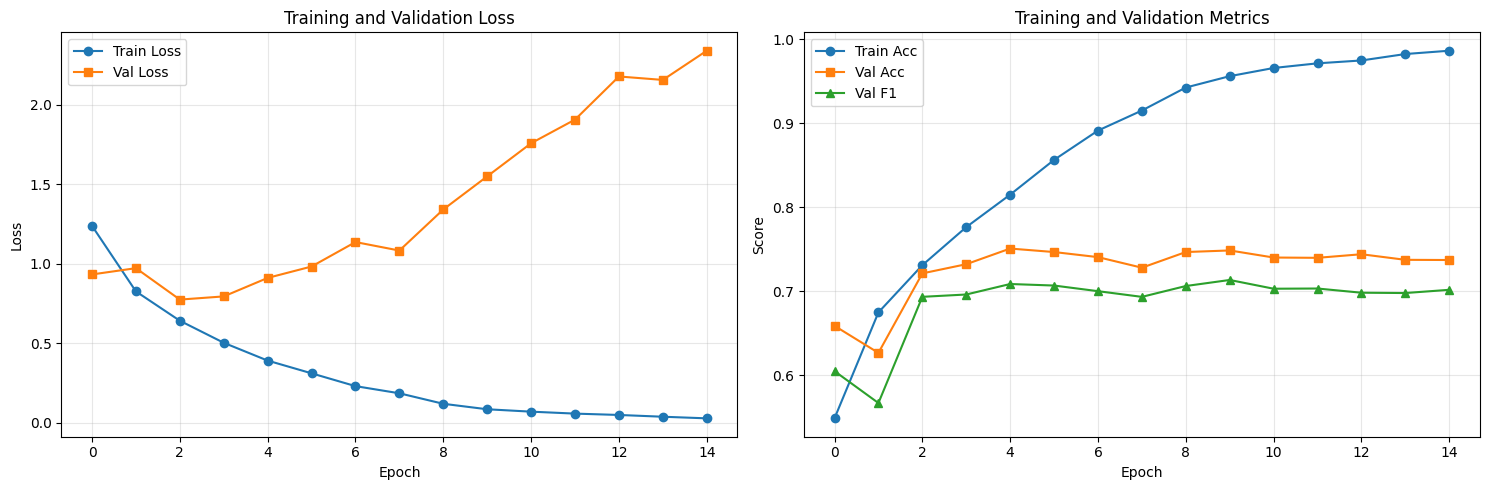

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(training_history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(training_history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(training_history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(training_history['val_acc'], label='Val Acc', marker='s')
axes[1].plot(training_history['val_f1'], label='Val F1', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Training and Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Model Evaluation and Comparison

In [ ]:
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Collect all metrics
models_comparison = {
    'Model': ['RoBERTa-base', 'DeBERTa-v3-large', 'BiLSTM+FastText'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_roberta),
        accuracy_score(y_test, y_pred_deberta),
        test_acc
    ],
    'Precision (Macro)': [
        precision_recall_fscore_support(y_test, y_pred_roberta, average='macro')[0],
        precision_recall_fscore_support(y_test, y_pred_deberta, average='macro')[0],
        test_precision
    ],
    'Recall (Macro)': [
        precision_recall_fscore_support(y_test, y_pred_roberta, average='macro')[1],
        precision_recall_fscore_support(y_test, y_pred_deberta, average='macro')[1],
        test_recall
    ],
    'F1 (Macro)': [
        precision_recall_fscore_support(y_test, y_pred_roberta, average='macro')[2],
        precision_recall_fscore_support(y_test, y_pred_deberta, average='macro')[2],
        test_f1
    ],
    'F1 (Weighted)': [
        precision_recall_fscore_support(y_test, y_pred_roberta, average='weighted')[2],
        precision_recall_fscore_support(y_test, y_pred_deberta, average='weighted')[2],
        precision_recall_fscore_support(y_test, y_pred_bilstm, average='weighted')[2]
    ]
}

comparison_df = pd.DataFrame(models_comparison)
print("\n")
print(comparison_df.to_string(index=False))

# Save comparison results
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("\n✓ Comparison results saved to 'model_comparison_results.csv'")


COMPREHENSIVE MODEL COMPARISON


           Model  Accuracy  Precision (Macro)  Recall (Macro)  F1 (Macro)  F1 (Weighted)
    RoBERTa-base  0.845847           0.824496        0.843577    0.832639       0.846356
DeBERTa-v3-large  0.853821           0.845050        0.847718    0.845473       0.854602
 BiLSTM+FastText  0.745135           0.699776        0.711241    0.705133       0.745269

✓ Comparison results saved to 'model_comparison_results.csv'


## 10. Results Visualization


CONFUSION MATRICES


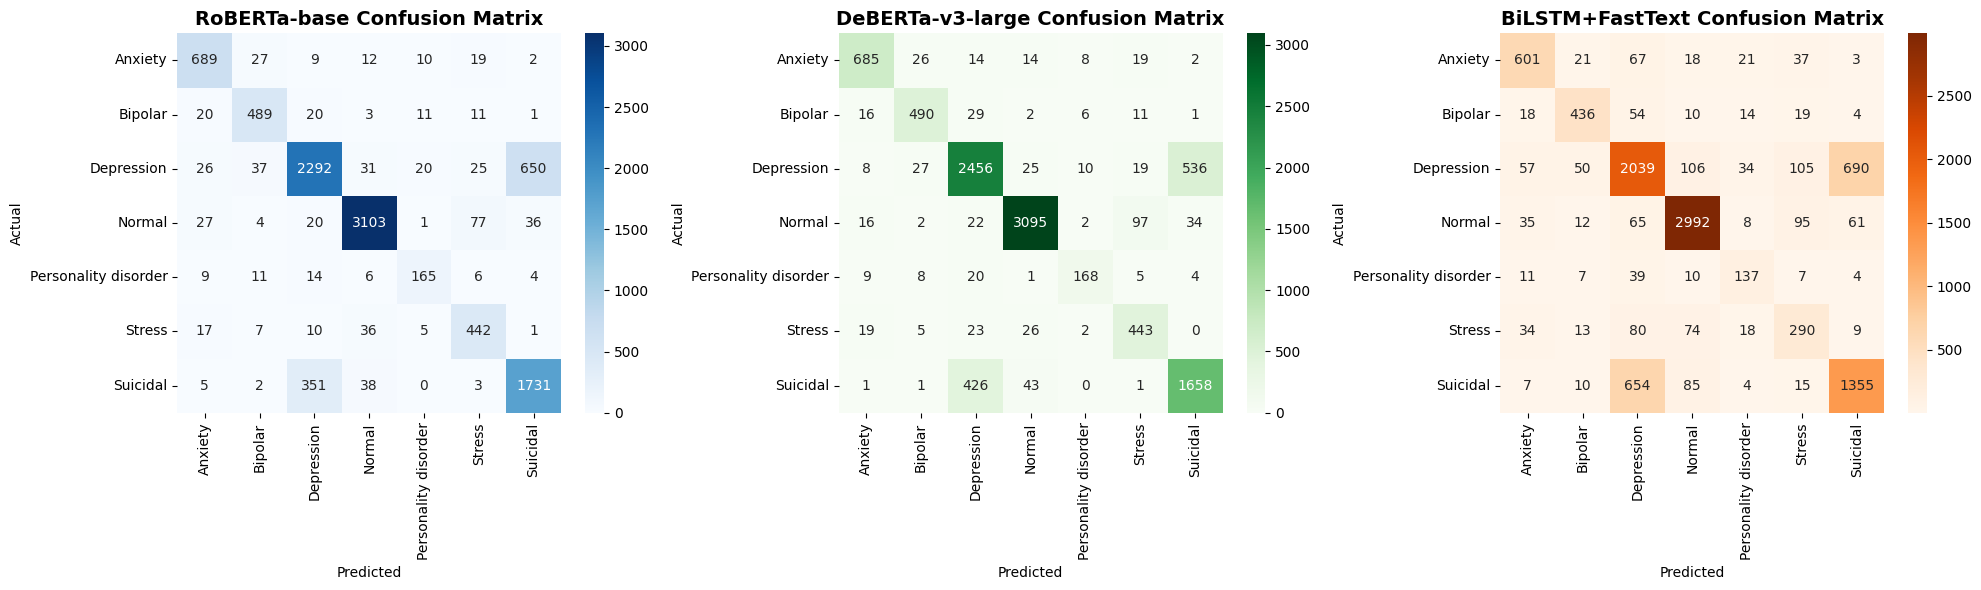

✓ Confusion matrices saved


In [ ]:
# Confusion Matrices
print("\n" + "="*80)
print("CONFUSION MATRICES")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# RoBERTa
cm_roberta = confusion_matrix(y_test, y_pred_roberta)
sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Blues',
            xticklabels=[reverse_label_mapping[i] for i in sorted(reverse_label_mapping.keys())],
            yticklabels=[reverse_label_mapping[i] for i in sorted(reverse_label_mapping.keys())],
            ax=axes[0])
axes[0].set_title('RoBERTa-base Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# DeBERTa
cm_deberta = confusion_matrix(y_test, y_pred_deberta)
sns.heatmap(cm_deberta, annot=True, fmt='d', cmap='Greens',
            xticklabels=[reverse_label_mapping[i] for i in sorted(reverse_label_mapping.keys())],
            yticklabels=[reverse_label_mapping[i] for i in sorted(reverse_label_mapping.keys())],
            ax=axes[1])
axes[1].set_title('DeBERTa-v3-large Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# BiLSTM
cm_bilstm = confusion_matrix(y_test, y_pred_bilstm)
sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=[reverse_label_mapping[i] for i in sorted(reverse_label_mapping.keys())],
            yticklabels=[reverse_label_mapping[i] for i in sorted(reverse_label_mapping.keys())],
            ax=axes[2])
axes[2].set_title('BiLSTM+FastText Confusion Matrix', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices saved")

In [ ]:
# Model Comparison Bar Chart
metrics_to_plot = ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1 (Macro)']

fig = go.Figure()
for metric in metrics_to_plot:
    fig.add_trace(go.Bar(
        name=metric,
        x=comparison_df['Model'],
        y=comparison_df[metric],
        text=comparison_df[metric].round(4),
        textposition='outside'
    ))

fig.update_layout(
    title="Model Performance Comparison (Macro Metrics)",
    xaxis_title="Model",
    yaxis_title="Score",
    barmode='group',
    height=500,
    yaxis_range=[0, 1.1]
)
fig.show()

print("✓ Model comparison visualization complete")

✓ Model comparison visualization complete


In [ ]:
# Final Summary
print("\n" + "="*80)
print("PROJECT SUMMARY")
print("="*80)

print("\n📊 Dataset Statistics:")
print(f"  - Total samples: {len(df)}")
print(f"  - Number of classes: {len(label_mapping)}")
print(f"  - Train samples: {len(X_train)}")
print(f"  - Validation samples: {len(X_val)}")
print(f"  - Test samples: {len(X_test)}")

print("\n🏆 Best Model Performance:")
best_model_idx = comparison_df['F1 (Macro)'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
best_f1 = comparison_df.loc[best_model_idx, 'F1 (Macro)']
print(f"  - Model: {best_model}")
print(f"  - Macro F1 Score: {best_f1:.4f}")

print("\n📈 All Models Performance Summary:")
for idx, row in comparison_df.iterrows():
    print(f"\n  {row['Model']}:")
    print(f"    - Accuracy: {row['Accuracy']:.4f}")
    print(f"    - Macro F1: {row['F1 (Macro)']:.4f}")
    print(f"    - Weighted F1: {row['F1 (Weighted)']:.4f}")

print("\n✅ All visualizations and results have been generated!")
print("="*80)


PROJECT SUMMARY

📊 Dataset Statistics:
  - Total samples: 52675
  - Number of classes: 7
  - Train samples: 33712
  - Validation samples: 8428
  - Test samples: 10535

🏆 Best Model Performance:
  - Model: DeBERTa-v3-large
  - Macro F1 Score: 0.8455

📈 All Models Performance Summary:

  RoBERTa-base:
    - Accuracy: 0.8458
    - Macro F1: 0.8326
    - Weighted F1: 0.8464

  DeBERTa-v3-large:
    - Accuracy: 0.8538
    - Macro F1: 0.8455
    - Weighted F1: 0.8546

  BiLSTM+FastText:
    - Accuracy: 0.7451
    - Macro F1: 0.7051
    - Weighted F1: 0.7453

✅ All visualizations and results have been generated!
